In [1]:
## Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import glob
import string
import statistics
from os.path import exists
from scipy.stats import norm
from scipy.stats import zscore
from scipy.stats import pearsonr  
from scipy.stats import chisquare
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import math
import scipy.stats

In [2]:
## define snodgrass correction and dprime calculation
def snodgrass(num,denom):
    return (float(num)+.5) / (float(denom) +1)

def dprime(hit,fa):
    return norm.ppf(hit,loc=0,scale=1) - norm.ppf(fa,loc=0,scale=1)

In [3]:
## Code taken from Craig Stark to find lines for the beginning of the study and test phases

def findlines(filename):
    s_starts=[]
    t_starts=[]
    with open(filename) as file:
        for linenum, linetxt in enumerate(file,1):
            if "Study phase started at" in linetxt:
                s_starts.append(linenum)
            elif "Test phase started at" in linetxt:
                t_starts.append(linenum)
    return (s_starts, t_starts)

In [4]:
def targ_trials(data):
    ## calculate number of Target Trials
    #initialize number of target trials to zero
    num_targ_trials = 0
    #loop through the data and add one if the condition is T (target) and the RT is greater than 400ms (avoid trials that cannot be real responses)
    for d in range(len(data)):
        if (data.loc[d, 'Cond'] == 'T') & ((data.loc[d, 'RT'] >400)|(data.loc[d, 'RT']==0)):
            num_targ_trials +=1
    return num_targ_trials

In [5]:
def foil_trials(data):
        ## calculate number of Foil Trials
    #initialize number of foil trials to zero
    num_foil_trials = 0
    #loop through the data and add one to the number of new trials if the condition is F (foil) & RT is greater than 400
    for g in range(len(data)):
        if (data.loc[g, 'Cond'] == 'F') & ((data.loc[g, 'RT'] > 400)|(data.loc[g, 'RT']==0)):
            num_foil_trials +=1
    return num_foil_trials

In [6]:
def lure_trials(data):
        ## calculate number of Lure Trials
    #initialize number of lure trials to zero
    num_lure_trials = 0
    #loop through the data and add one to the number of lure trials if the condition is L (Lure) AND "real" response
    for f in range(len(data)):
        if (data.loc[f, 'Cond'] == 'L') & ((data.loc[f, 'RT'] > 400)| (data.loc[f, 'RT']==0)):
            num_lure_trials +=1
    return num_lure_trials 

In [7]:
def no_resp(data):
     ## calculate total number of no response

    #initialize nuumber of no resposnses to zero
    num_nr = 0
    #for loop through the data and add one if the response is 0 (meaning no response)
    for n in range(len(data)):
        if (data.loc[n, 'Resp'] == 0):
            num_nr +=1  
    
     ## calculate number of no responses to Targets

    #initialize number of no responses to targets to zero
    num_nr_targ = 0
    #loop through the data and add one to number of no responses to targets
    #if the response is 0 (no response) and the condition is T (target);
    for a in range(len(data)):
        if (data.loc[a, 'Resp'] ==0) & (data.loc[a, 'Cond'] == 'T'):
            num_nr_targ +=1
            
         ## calculate number of no responses to Lures

    #initialize number of no responses to lures to zero
    num_nr_lure = 0
    #loop through the data and add one to the number of no responses to lures 
    #if the response is 0 (no response) and the condition is L (Lure)
    for b in range(len(data)):
        if (data.loc[b, 'Resp'] == 0) & (data.loc[b, 'Cond'] =='L'):
            num_nr_lure+=1

    ## calculate number of no responses to Foils

    #initialize number of no responses to foils to zero
    num_nr_foil = 0
    #loop through the data and add one to the number of no responses to foils
    #if the response is 0 (no response) and the condition is F (foil)
    for c in range(len(data)):
        if (data.loc[c, 'Resp'] == 0) & (data.loc[c,'Cond'] == 'F'):
            num_nr_foil+=1
            
    #caluclate the proportion of no responses overall by taking the number of overall responses and dividing it by the number of trials (192 in this case)        
    prop_nr = num_nr/192

    # return the number of no responses overall, to targets, to lures, to foils, and the proportion of NR overall
    return num_nr, num_nr_targ, num_nr_lure, num_nr_foil, prop_nr

In [8]:
def targ_resp(data):
    ## calculate number of target trials using function defined above
    num_targ_trials = targ_trials(data)
    ## calculate number of Old|Target

    #initialize the number of Target|Old to zero
    num_old_targ = 0
    #loop through the data and add one to the number of of Old|Target 
    #if the condition is T (target) and if the response is 1 (Old) & RT is greater than 400
    for j in range(len(data)):
        if ((data.loc[j, 'Cond'] == 'T') & (data.loc[j, 'Resp'] == 1) & (data.loc[j, 'RT']>400)):
            num_old_targ +=1

    ## Calculate proportion of Old|Target for ALL Target Trials

    #Divide the number of old|target by the total number of target trials
    prop_old_targ = num_old_targ/num_targ_trials
    
    ## Calculate number of Similar|Target

    #initialize the number of Similar|Target to zero
    num_sim_targ = 0

    #loop through the data and add one to the number of Similar|Target 
    #if the condition is T (target) and if the participant responsed 2 (Similar) & RT is greater than 400
    for k in range(len(data)):
        if ((data.loc[k, 'Cond']=='T') & (data.loc[k, 'Resp']==2) &(data.loc[k, 'RT']>400)):
            num_sim_targ+=1

    ## calculate proportion of Similar|target for all target trials

    #divide the number of Similar|target by the total number of target trials
    prop_sim_targ= num_sim_targ/num_targ_trials

    ## calculate number of New|Target

    # initialize the number of New|Target to zero
    num_new_targ = 0
    #loop through the data and add one to the number of New|Target
    #if the condition is T(Target) and if the participant responded 3(New) & RT is greater than 400
    for l in range(len(data)):
        if ((data.loc[l, 'Cond'] == 'T') & (data.loc[l, 'Resp'] == 3) & (data.loc[l, 'RT']>400)):
            num_new_targ+=1
    
    ## calculate the proportion of New|Target for all target trials

    #divide number of New|Target by the total number of target trials
    prop_new_targ = num_new_targ/num_targ_trials
   
    # return the number and proportion of each response type for targets
    return num_old_targ, prop_old_targ, num_sim_targ, prop_sim_targ, num_new_targ, prop_new_targ

In [9]:
def lure_resp(data):
    num_lure_trials = lure_trials(data)
    ## calculate number of Old|Lure using function defined above

    #Initialize the number of Old|Lure to zero
    num_old_lure = 0
    #loop through the data and add one to the number of Old|Lure 
    # if the condition is L (Lure) and the participant responded 1 (Old) & RT is greater than 400
    for m in range(len(data)):
        if ((data.loc[m, 'Cond']=='L') & (data.loc[m, 'Resp'] == 1) & (data.loc[m, 'RT']>400)) :
            num_old_lure+=1
   
    ## calculate the proportion of Old|Lure for all lure trials

    #divide number of Old|Lure by the total number of lure trials
    prop_old_lure = num_old_lure/num_lure_trials
    
       ## calculate number of Similar|Lure

    #Initialize the number of Similar|Lure to zero
    num_sim_lure = 0
    #loop through the data and add one to the number of Similar|Lure
    #if the condition is L (Lure) and the participant responded 2 (Similar) &  RT is greater than 400
    for o in range(len(data)):
        if ((data.loc[o, 'Cond']=="L") & (data.loc[o, 'Resp'] == 2) & (data.loc[o, 'RT']>400)):
            num_sim_lure+=1

    ## Calculate the proportion of Similar|Lure for all lure trials

    #divide number of Similar|Lure by the total number of lure trials
    prop_sim_lure = num_sim_lure/num_lure_trials
    
    ## calculate number of New|Lure

    #Initialize the number of New|Lure to zero
    num_new_lure = 0
    #loop through the data and add one to the number of New|Lure
    #if the condition is L(Lure) and the participant responded 3 (New) & RT is greater than 400
    for p in range(len(data)):
        if ((data.loc[p, 'Cond']=='L') & (data.loc[p, 'Resp']== 3) & (data.loc[p, 'RT']>400)):
            num_new_lure+=1

    ## calculate proportion of new|lure for all lure trials

    #divide number of new|lure by the total number of lure trials
    prop_new_lure = num_new_lure/num_lure_trials
    
    #return the number and proportion of each response type to lures

    return num_old_lure, prop_old_lure, num_sim_lure, prop_sim_lure, num_new_lure, prop_new_lure

In [10]:
def foil_resp(data):
    ## calculate number of foil trials using function defined above
    num_foil_trials = foil_trials(data)
      ## calculate number of Old|Foil
     #Initialize the number of Old|Foil
    num_old_foil = 0
    #loop throught the data and add one to the number of Old|Foil
    #if the condition is F (Foil) and the participant responded 1 (Old) &  RT is greater than 400
    for q in range(len(data)):
        if ((data.loc[q, 'Cond'] == 'F') & (data.loc[q, 'Resp'] == 1) &(data.loc[q, 'RT']>400)):
            num_old_foil+=1

    ## calculate proportion of old|foil for all foil trials

    #divide number of old|foil by the total number of foil trials
    prop_old_foil = num_old_foil/num_foil_trials
    
    ##calculate number of Similar|Foil

    #Initialize the number of Similar|Foil to zero
    num_sim_foil = 0
    #loop through the data and add one to the number of Similar|Foil
    #if the condition is F(Foil) and the participant responded 2(similar) &  RT is greater than 400
    for r in range(len(data)):
        if ((data.loc[r, 'Cond'] == 'F') & (data.loc[r, 'Resp'] == 2) & (data.loc[r, 'RT']>400)):
            num_sim_foil+=1

      ## calculate proportion of similar|foil for all foil trials

    #divide the number of similar|foil by the number of foil trials
    prop_sim_foil = num_sim_foil/num_foil_trials
    
    ##calculate nummber of New|Foil

    #Initialize the number of New|Foil to zero
    num_new_foil = 0
    #Loop through the data and add one to the number of New|Foil
    #if the condition is F(Foil) and the participant responded 3(New) &  RT is greater than 400
    for s in range(len(data)):
        if ((data.loc[s, 'Cond'] == 'F') & (data.loc[s, 'Resp'] == 3) & (data.loc[s, 'RT']>400)):
            num_new_foil+=1

   
    
    
    ## calculate proportion of new|foil for all foil trials 

    #divide the number of new|foil by the total number of foil trials
    prop_new_foil = num_new_foil/num_foil_trials

    #return the number and proportion of each response type to foil trials
    return num_old_foil, prop_old_foil, num_sim_foil, prop_sim_foil, num_new_foil, prop_new_foil

In [11]:
## define the calculation of correct answers
def corr_ans(data):
    #calculate the number of each condition based on defintions above
    num_targ_trials = targ_trials(data)
    num_lure_trials = lure_trials(data)
    num_foil_trials = foil_trials(data)
    #set the number each correct response to zero
    num_new_foil = 0
    num_old_targ = 0
    num_sim_lure = 0 
    #count the number of correct foil trials
    for s in range(len(data)):
        if ((data.loc[s, 'Cond'] == 'F') & (data.loc[s, 'Resp'] == 3) & (data.loc[s, 'RT']>400)):
            num_new_foil+=1
    
    #count the number of correct target trials
    for j in range(len(data)):
        if ((data.loc[j, 'Cond'] == 'T') & (data.loc[j, 'Resp'] == 1) & (data.loc[j, 'RT']>400)):
            num_old_targ +=1
    #cound the number of correct lure trials 
    for o in range(len(data)):
        if ((data.loc[o, 'Cond']=="L") & (data.loc[o, 'Resp'] == 2) & (data.loc[o, 'RT']>400)):
            num_sim_lure+=1

    ## Calculate number of correct responses 
    #add the number of correct responses (New|Foil, Old|Target, Sim|Lure)
    corr_resp = num_new_foil + num_old_targ + num_sim_lure

    ## calculate proportion of correct responses

    prop_corr_resp = corr_resp/(num_targ_trials + num_lure_trials + num_foil_trials)
    
    #return the number and proportion of correct responses overall
    return corr_resp, prop_corr_resp

In [12]:
def calc_bps(prop_sim_lure, prop_sim_foil):
    ## calculate BPS Score

    # subtract the proportion of sim|foil from the proportion of sim|lure
    bps_score = prop_sim_lure - prop_sim_foil
    return bps_score

In [13]:
def recog_scores(prop_old_targ, prop_old_foil, prop_old_lure, prop_sim_lure):
    ## calculate traditional recognition score

    #subtract the proportion of old|foil from the proportion of old|targ
    recog_targ_foil= prop_old_targ-prop_old_foil
    
    ## calculate other recognition score

    ## subtract old|lure from old|target
    recog_targ_lure = prop_old_targ - prop_old_lure
    
    
    return recog_targ_foil, recog_targ_lure

In [14]:
##create wide data frame called all_data

#define variables
all_data=pd.DataFrame()
demo_data = pd.read_csv('/Users/madisonhunt/Desktop/Oak/stark_task/stark_demographics.csv')
row=0
missing=0
has_data=0
n_stim_per=64
study_len = n_stim_per*2
test_len = n_stim_per*3

pidn_list=demo_data['pidn']
#read in files accounting for change in nomenclature throughout study
for pidn in pidn_list:

    if pidn < 685:
        filename = '/Users/madisonhunt/Desktop/Oak/stark_task/Data/BPSOlog_0{}.txt'.format(pidn)
#         print(filename)
    elif pidn > 685:
        filename = '/Users/madisonhunt/Desktop/Oak/stark_task/Data/MSTlog_0{}.txt'.format(pidn)
#         print(filename)
        if pidn > 1000: 
            filename = '/Users/madisonhunt/Desktop/Oak/stark_task/Data/MSTlog_{}.txt'.format(pidn)
    #         print(filename)

    if exists(filename):

        has_data +=1
        
        #code to read in data from Craig Stark
        s_starts, t_starts = findlines(filename)
        if len(s_starts) & len(t_starts):
            study_starts = s_starts[-1]
            test_starts = t_starts[-1]
            pt_data =  pd.read_csv(filename, delimiter="\t", skiprows= test_starts, nrows=test_len, header = 0)     

            all_data.loc[row, 'pidn'] = pidn 
            #calculate stark data from txt file using functions defined above
            all_data.loc[row, 'num_targ_tr']  = targ_trials(pt_data)             
            all_data.loc[row, 'num_foil_tr'] = foil_trials(pt_data)
            all_data.loc[row, 'num_lure_tr'] = lure_trials(pt_data)
            [all_data.loc[row, 'num_nr'], all_data.loc[row, 'num_nr_t'], 
             all_data.loc[row, 'num_nr_l'], all_data.loc[row, 'num_nr_f'],
             all_data.loc[row, 'prop_nr']] = no_resp(pt_data)
            [all_data.loc[row, 'n_old_targ'], all_data.loc[row, 'p_old_targ'], 
             all_data.loc[row, 'n_sim_targ'], all_data.loc[row, 'p_sim_targ'],
             all_data.loc[row, 'n_new_targ'], all_data.loc[row, 'p_new_targ']] = targ_resp(pt_data)
            [all_data.loc[row, 'n_old_lure'], all_data.loc[row, 'p_old_lure'],
            all_data.loc[row, 'n_sim_lure'], all_data.loc[row, 'p_sim_lure'],
            all_data.loc[row, 'n_new_lure'], all_data.loc[row, 'p_new_lure']] = lure_resp(pt_data)
            [all_data.loc[row, 'n_old_foil'], all_data.loc[row, 'p_old_foil'],
            all_data.loc[row, 'n_sim_foil'], all_data.loc[row, 'p_sim_foil'], 
            all_data.loc[row, 'n_new_foil'], all_data.loc[row, 'p_new_foil']] = foil_resp(pt_data)
            [all_data.loc[row, 'n_correct'], all_data.loc[row, 'p_correct']] = corr_ans(pt_data)
            all_data.loc[row, 'bps'] = calc_bps(all_data.loc[row, 'p_sim_lure'], all_data.loc[row, 'p_sim_foil'])
            [all_data.loc[row, 'old_targ_old_foil'], all_data.loc[row, 'old_targ_old_lure']] = recog_scores(all_data.loc[row, 'p_old_targ'], all_data.loc[row, 'p_old_foil'], all_data.loc[row,'p_old_lure'],  all_data.loc[row, 'p_sim_lure'])
            all_data.loc[row, 'dprime_old_new'] = dprime((snodgrass(all_data.loc[row, 'n_old_targ'], all_data.loc[row, 'num_targ_tr'])), (snodgrass(all_data.loc[row, 'n_old_foil'], all_data.loc[row, 'num_foil_tr'])))
            all_data.loc[row,'dprime_old_lure'] = dprime((snodgrass(all_data.loc[row, 'n_old_targ'], all_data.loc[row, 'num_targ_tr'])), (snodgrass(all_data.loc[row, 'n_old_lure'], all_data.loc[row, 'num_lure_tr'])))
            all_data.loc[row, 'dprime_bps'] = dprime((snodgrass(all_data.loc[row, 'n_sim_lure'], all_data.loc[row, 'num_lure_tr'])), (snodgrass(all_data.loc[row, 'n_sim_foil'], all_data.loc[row, 'num_foil_tr'])))
            row +=1
        else: print(pidn)
    else:
        missing +=1

#remove pidns that are excluded from analysis for having a low old/new recognition score
all_data= all_data[(all_data['pidn']!=528) & (all_data['pidn']!=866) &(all_data['pidn']!=1230)]

616
1141


In [15]:
print(all_data[all_data['pidn']==646]['num_targ_tr'])

41    57.0
Name: num_targ_tr, dtype: float64


In [16]:
#read in demographic and neuropsych data from file on Oak
demo_data = pd.read_csv('/Users/madisonhunt/Desktop/Oak/stark_task/stark_demographics.csv')
#merge this data with the MST data
all_data= all_data.merge(demo_data, on='pidn')

In [17]:
## create a long-format data frame
data_long=pd.DataFrame()
n_stim_per=64
study_len = n_stim_per*2
test_len = n_stim_per*3
#read in sheet with demographics & NP scores
demo_data = pd.read_csv('/Users/madisonhunt/Desktop/Oak/stark_task/stark_demographics.csv')
pidn_list = demo_data['pidn']
#forloop through pidns and adjust the filename based on nomenclature changes throughout the study
for pidn in pidn_list:
    if pidn != 999 and pidn !=685:
        if pidn < 685:
            filename = '/Users/madisonhunt/Desktop/Oak/stark_task/Data/BPSOlog_0{}.txt'.format(pidn)
           
        if pidn > 685:
            if pidn < 1000:
#         elif pidn > 685 and pidn <1000:
                filename = '/Users/madisonhunt/Desktop/Oak/stark_task/Data/MSTlog_0{}.txt'.format(pidn)
                
            else:
                filename = '/Users/madisonhunt/Desktop/Oak/stark_task/Data/MSTlog_{}.txt'.format(pidn)
                
# read in files using Craig Stark's code
        if exists(filename):

            s_starts, t_starts = findlines(filename)
            if len(s_starts) & len(t_starts):
                study_starts = s_starts[-1]
                test_starts = t_starts[-1]
                pt_data =  pd.read_csv(filename, delimiter="\t", skiprows= test_starts, nrows=test_len, header = 0)     

                pt_data['pidn'] = pidn
                
                data_long = data_long.append(pt_data,ignore_index=True)
#remove participants who were excluded for having low old/new d'
data_long=data_long[(data_long['pidn']!=528) &(data_long['pidn']!=866) &(data_long['pidn']!=1230)]
 ## remove any trials below 400 ms
data_long=data_long[(data_long['RT']>400) | (data_long['RT'] ==0)]

In [18]:
## Change data in data long to be easily readable

#change response column
data_long.loc[data_long['Resp']==1,'Resp'] = 'Old'
data_long.loc[data_long['Resp']==2,'Resp'] = 'Similar'
data_long.loc[data_long['Resp']==3,'Resp'] = 'New'
data_long.loc[data_long['Resp']==0,'Resp'] = 'No Resp'

#Change condition column
data_long.loc[data_long['Cond'] == 'T', 'Cond'] = 'Target'
data_long.loc[data_long['Cond'] == 'L', 'Cond'] = 'Lure'
data_long.loc[data_long['Cond'] == 'F', 'Cond'] = 'Foil'

#change accuracy column
data_long.loc[data_long['Acc'] ==1, 'Acc'] = 'Correct'
data_long.loc[data_long['Acc'] == 0, 'Acc'] ='Incorrect'



In [19]:
# put people into nr_groups based on their proportion of no response
all_data.loc[all_data['prop_nr']>=.20, 'nr_group'] = 'nr_.20'
all_data.loc[(all_data['prop_nr']>=.15)&(all_data['prop_nr']<.20), 'nr_group'] = 'nr_.15'
all_data.loc[(all_data['prop_nr']>=.10)&(all_data['prop_nr']<.15), 'nr_group'] = 'nr_.10'
all_data.loc[(all_data['prop_nr']>=.05)&(all_data['prop_nr']<.10), 'nr_group'] = 'nr_.05'
all_data.loc[(all_data['prop_nr']<.05), 'nr_group'] = 'nr_low'

In [20]:
## create data frames for reaction times

#overall RT data frame
med_rt_all = data_long.groupby('pidn').median().reset_index()
#RT by condition data frame
med_rt_cond = data_long.groupby(['pidn', 'Cond']).median().reset_index()
#RT by accuracy data frame
med_rt_acc = data_long.groupby(['pidn', 'Acc']).median().reset_index()
#RT by condition and response data frame
med_rt_resp = data_long.groupby(['pidn', 'Cond', 'Resp']).median().reset_index()
#RT by condition and accuracy data frame
med_rt_cond_acc = data_long.groupby(['pidn', 'Cond', 'Acc']).median().reset_index()


In [21]:
## finalize RT data frames by merging them with all_data (in order to have summary metrics)
med_rt_all = med_rt_all.merge(all_data, on='pidn')
med_rt_cond = med_rt_cond.merge(all_data, on='pidn')
med_rt_acc = med_rt_acc.merge(all_data, on='pidn')
med_rt_resp = med_rt_resp.merge(all_data, on='pidn')
med_rt_cond_acc = med_rt_cond_acc.merge(all_data, on='pidn')

#print one data frame to check that the merge happened correctly
med_rt_cond_acc.head()

,pidn,Cond,Acc,Trial,LBin,RT,num_targ_tr,num_foil_tr,num_lure_tr,num_nr,...,lm2,lmpr,mmse_norm,hvltr4_norm,bvmtr4_norm,lm2_norm,immediate_recall_comp,delayed_recall_comp,recognition_comp,nr_group
0,449,Foil,Correct,104.0,0.0,1404.0,63.0,63.0,63.0,15.0,...,33.0,89.0,0.986161,0.461898,0.992866,0.338361,0.87116,0.597709,-0.311304,nr_.05
1,449,Foil,Incorrect,93.5,0.0,1232.5,63.0,63.0,63.0,15.0,...,33.0,89.0,0.986161,0.461898,0.992866,0.338361,0.87116,0.597709,-0.311304,nr_.05
2,449,Lure,Correct,77.0,4.0,1785.0,63.0,63.0,63.0,15.0,...,33.0,89.0,0.986161,0.461898,0.992866,0.338361,0.87116,0.597709,-0.311304,nr_.05
3,449,Lure,Incorrect,90.0,3.0,1189.0,63.0,63.0,63.0,15.0,...,33.0,89.0,0.986161,0.461898,0.992866,0.338361,0.87116,0.597709,-0.311304,nr_.05
4,449,Target,Correct,107.0,0.0,1132.0,63.0,63.0,63.0,15.0,...,33.0,89.0,0.986161,0.461898,0.992866,0.338361,0.87116,0.597709,-0.311304,nr_.05


/Users/madisonhunt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[(0, 1)]

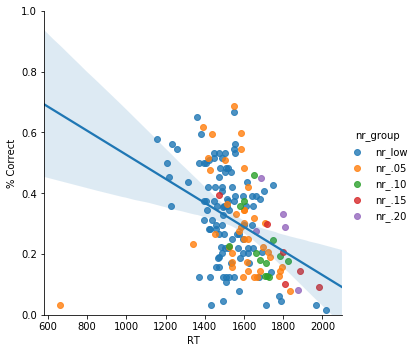

In [22]:
#plot the correct RT verusus the proportion correct for lure trials
g=sns.lmplot(x='RT', y ='p_sim_lure', data=med_rt_cond_acc[(med_rt_cond_acc['Cond']=='Lure') & (med_rt_cond_acc['Acc']=='Correct')], hue= 'nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='RT', y='p_sim_lure', data=med_rt_cond_acc[(med_rt_cond_acc['Cond']=='Lure') & (med_rt_cond_acc['Acc']=='Correct')], scatter=False)
plt.ylabel('% Correct')
g.set(ylim=[0, 1])

[(0, 1)]

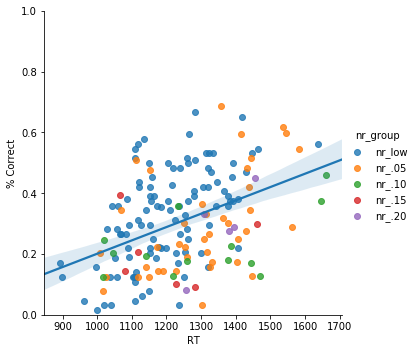

In [23]:
# plot the incorrect RT versus proportion correct on lure trials
g=sns.lmplot(x='RT', y ='p_sim_lure', data=med_rt_cond_acc[(med_rt_cond_acc['Cond']=='Lure') & (med_rt_cond_acc['Acc']=='Incorrect')], hue= 'nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='RT', y='p_sim_lure', data=med_rt_cond_acc[(med_rt_cond_acc['Cond']=='Lure') & (med_rt_cond_acc['Acc']=='Incorrect')], scatter=False)
plt.ylabel('% Correct')
g.set(ylim=[0, 1])

[(0, 1)]

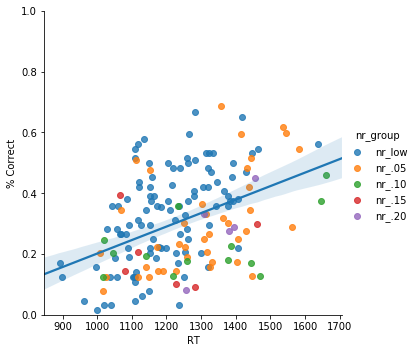

In [24]:
#plot the incorrect RT versus the proportion correct for lure trials after excluding the outlier
temp4 = med_rt_cond_acc[med_rt_cond_acc['pidn']!=1185]
g=sns.lmplot(x='RT', y ='p_sim_lure', data=temp4[(temp4['Cond']=='Lure') & (temp4['Acc']=='Incorrect')], hue= 'nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='RT', y='p_sim_lure', data=temp4[(temp4['Cond']=='Lure') & (temp4['Acc']=='Incorrect')], scatter=False)
plt.ylabel('% Correct')
g.set(ylim=[0, 1])


# Start code for NP scores

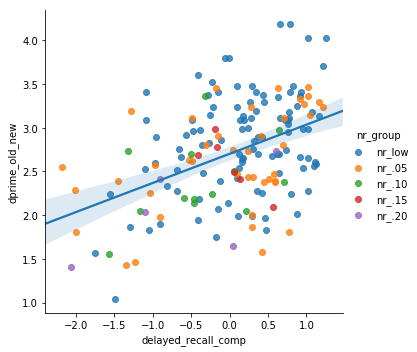

In [25]:
## plot the delayed recall composite versus d' old/new on mst task and color code for nr group
g=sns.lmplot(x='delayed_recall_comp', y='dprime_old_new', data=all_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='delayed_recall_comp', y='dprime_old_new', data=all_data, scatter=False)

In [26]:
# calculate the correlation values for delayed recall comp vs old/new d' on mst task
pearsonr(x=all_data['delayed_recall_comp'], y=all_data['dprime_old_new'])

(0.44268818612161026, 1.338960243001133e-09)

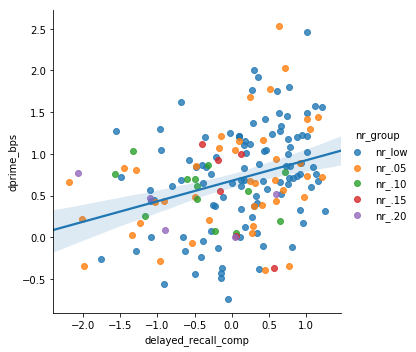

In [27]:
#plot the delayed recall composite vs d' bps and color code by nr group
g=sns.lmplot(x='delayed_recall_comp', y='dprime_bps', data=all_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='delayed_recall_comp', y='dprime_bps', data=all_data, scatter=False)

In [28]:
# calculate the correlation value for delayed recall and d' bps 
pearsonr(x=all_data['delayed_recall_comp'], y=all_data['dprime_bps'])

(0.31602447891998714, 2.5461677214474242e-05)

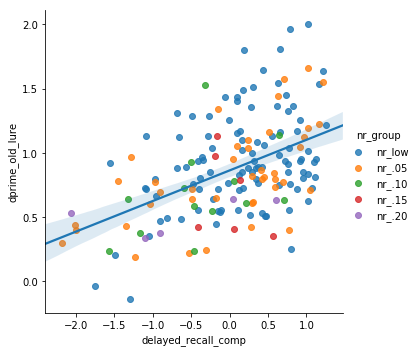

In [29]:
#plot the delayed recall composite versus the d' old/lure and color code by nr group
g=sns.lmplot(x='delayed_recall_comp', y='dprime_old_lure', data=all_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='delayed_recall_comp', y='dprime_old_lure', data=all_data, scatter=False)

In [30]:
#calculate correlation value delayed recall vs d' old/lure
pearsonr(x=all_data['delayed_recall_comp'], y=all_data['dprime_old_lure'])

(0.4784489041734775, 3.62713108719362e-11)

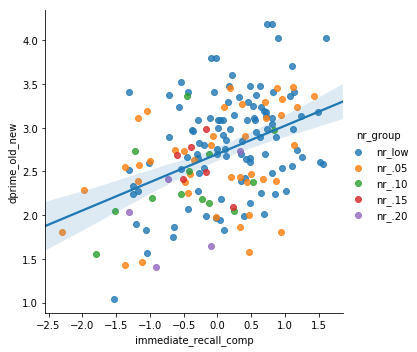

In [31]:
#plot the immediate recall composite versus the old/new d'
g=sns.lmplot(x='immediate_recall_comp', y='dprime_old_new', data=all_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='immediate_recall_comp', y='dprime_old_new', data=all_data, scatter=False)

In [32]:
# calculate the correlation value for immediate recall versus d' old/new
pearsonr(x=all_data['immediate_recall_comp'], y=all_data['dprime_old_new'])

(0.43208473603665365, 3.611264919805064e-09)

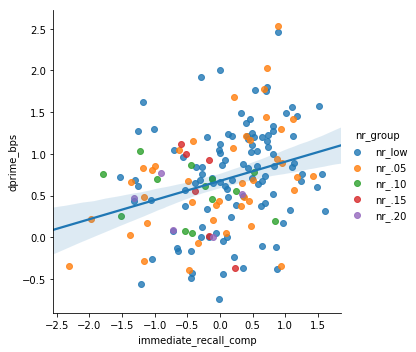

In [33]:
#plot the immediate recall versus d' bps
g=sns.lmplot(x='immediate_recall_comp', y='dprime_bps', data=all_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='immediate_recall_comp', y='dprime_bps', data=all_data, scatter=False)

In [34]:
#calculate the correlation value for immediate recall versus d' bps
pearsonr(x=all_data['immediate_recall_comp'], y=all_data['dprime_bps'])

(0.2980317603421685, 7.525282204666928e-05)

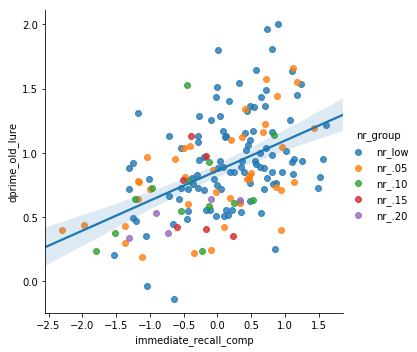

In [35]:
# plot the immediate recall vs d' old/lure
g=sns.lmplot(x='immediate_recall_comp', y='dprime_old_lure', data=all_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='immediate_recall_comp', y='dprime_old_lure', data=all_data, scatter=False)

In [36]:
# calculate the correlation value for immediate recall versus d' old/lure
pearsonr(x=all_data['immediate_recall_comp'], y=all_data['dprime_old_lure'])

(0.4727508840291674, 6.630819369190148e-11)

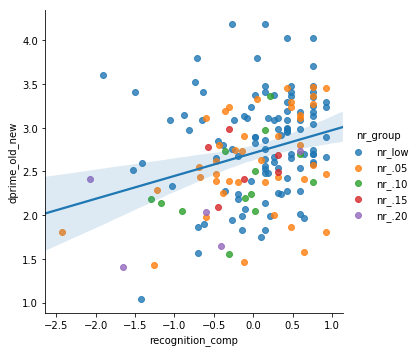

In [37]:
#plot the recognition composite versus d' old/new
g=sns.lmplot(x='recognition_comp', y='dprime_old_new', data=all_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='recognition_comp', y='dprime_old_new', data=all_data, scatter=False)

In [38]:
# calculate the correlation value for recognition composite versus d' old/new
pearsonr(x=all_data['recognition_comp'], y=all_data['dprime_old_new'])

(0.2920660800102, 0.00010614190071087627)

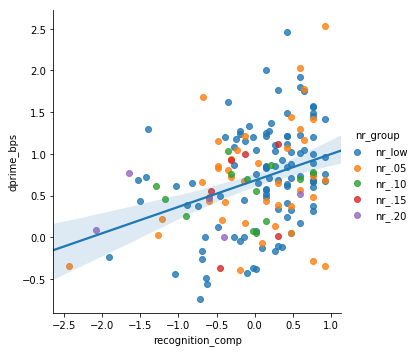

In [39]:
#plot the recognition composite versus d' bps
g=sns.lmplot(x='recognition_comp', y='dprime_bps', data=all_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='recognition_comp', y='dprime_bps', data=all_data, scatter=False)

In [40]:
# calculate the correlation value for recognition composite versus d' bps
pearsonr(x=all_data['recognition_comp'], y=all_data['dprime_bps'])

(0.3421821434923746, 4.631064219192963e-06)

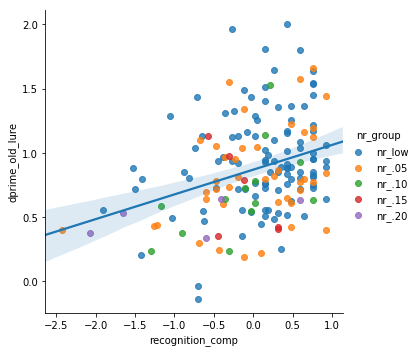

In [41]:
#plot the recognition composite vs d' old/lure
g=sns.lmplot(x='recognition_comp', y='dprime_old_lure', data=all_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='recognition_comp', y='dprime_old_lure', data=all_data, scatter=False)

In [42]:
#calculate the correlation value for recognition composite versus d' old/lure
pearsonr(x=all_data['recognition_comp'], y=all_data['dprime_old_lure'])

(0.3253146720805161, 1.4149722264208363e-05)

# End NP code

# Start AM Code

In [43]:
## read in AM data into dataframe
am = pd.read_csv('/Users/madisonhunt/Desktop/Oak/stark_task/md_np_am_data.csv')
#create AM data frame
am_data=pd.DataFrame()
row=0
#add pidn, associative d' and o/n d' to data frame
for pid in pd.unique(all_data['pidn']):
    am_data.loc[row, 'pidn'] = pid
    am_data.loc[row, 'assoc_d'] = am.loc[row, 'associative_dprime']
    am_data.loc[row, 'old_new_d'] = am.loc[row, 'overall_dprime']
    row+=1
    
#drop any N/A (people who don't have AM scores) from the data frame. reset the index without creating a new column for the old indices
am_data=am_data.dropna().reset_index(drop=True)

#check that the data is correct
am_data.head()

,pidn,assoc_d,old_new_d
0,457.0,1.151484,1.517441
1,472.0,1.062976,1.729088
2,474.0,2.058239,3.317012
3,475.0,0.567947,1.461771
4,476.0,2.235338,2.418288


In [44]:
#merge the am data with the mst data
am_data= am_data.merge(all_data, on='pidn')

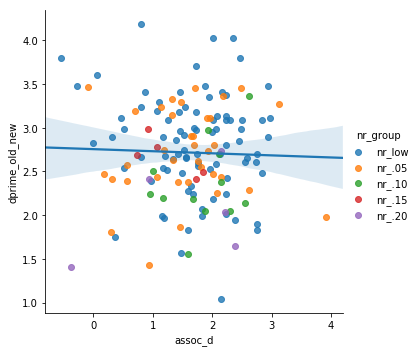

In [45]:
#plot the AM associative d' vs the MST old/new d'
sns.lmplot(x='assoc_d', y='dprime_old_new', data=am_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
sns.regplot(x='assoc_d', y='dprime_old_new', data=am_data, scatter=False)

In [46]:
#calculate the correlation value for the associative d' versus the d' old/new
pearsonr(x= am_data['assoc_d'], y=am_data['dprime_old_new'])

(-0.032391310265580134, 0.698927453879346)

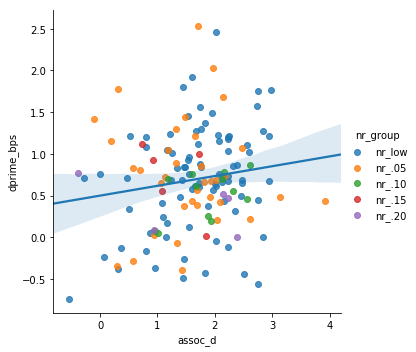

In [47]:
#plot the AM associative d' versus MST d' BPS
sns.lmplot(x='assoc_d', y='dprime_bps', data=am_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
sns.regplot(x='assoc_d', y='dprime_bps', data=am_data, scatter=False)

In [48]:
#calucate the correlation value for associative d' vs d' BPS
pearsonr(x= am_data['assoc_d'], y=am_data['dprime_bps'])

(0.15219732342876385, 0.06762493903379604)

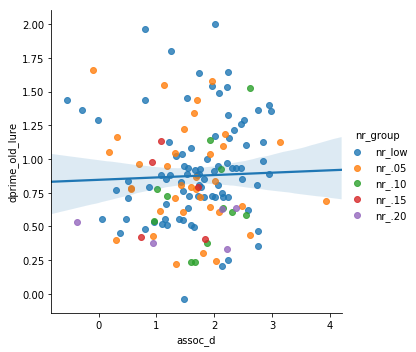

In [49]:
#plot the AM associative d' versus MST Old/Sim d'
sns.lmplot(x='assoc_d', y='dprime_old_lure', data=am_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
sns.regplot(x='assoc_d', y='dprime_old_lure', data=am_data, scatter=False)

In [50]:
#calucate the correlation value for associative d' vs d' old/similar
pearsonr(x= am_data['assoc_d'], y=am_data['dprime_old_lure'])

(0.03554188969445214, 0.671266130169093)

Text(30.973967013888902, 0.5, 'MST Old/New')

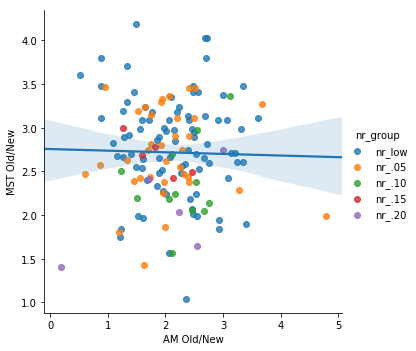

In [51]:
#plot the AM old/new d' versus the MST old/new d'
sns.lmplot(x='old_new_d', y='dprime_old_new', data=am_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
sns.regplot(x='old_new_d', y='dprime_old_new', data=am_data, scatter=False)
plt.xlabel('AM Old/New')
plt.ylabel('MST Old/New')

In [52]:
# calculate the correlation value of AM old/new d' vs MST old/new d'
pearsonr(x=am_data['old_new_d'], y=am_data['dprime_old_new'])

(-0.022944662787432037, 0.784134511327277)

Text(32.543758680555555, 0.5, 'MST BPS')

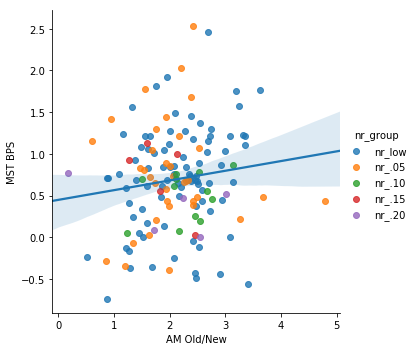

In [53]:
#plot the AM old/new versus the MST d' BPS
sns.lmplot(x='old_new_d', y='dprime_bps', data=am_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
sns.regplot(x='old_new_d', y='dprime_bps', data=am_data, scatter=False)
plt.xlabel('AM Old/New')
plt.ylabel('MST BPS')

In [54]:
# calculate the correlation value of AM old/new d' vs MST BPS d'
pearsonr(x=am_data['old_new_d'], y=am_data['dprime_bps'])

(0.13663706887345173, 0.10125843313292951)

Text(32.18698784722223, 0.5, 'MST Old/Sim')

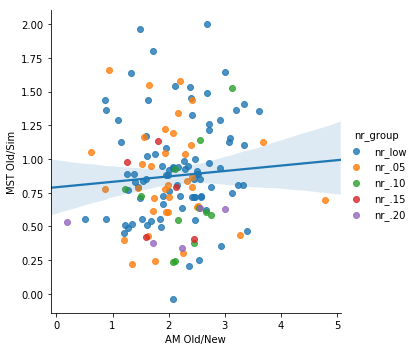

In [55]:
#plot the AM old/new d' versus the MST old/sim d'
sns.lmplot(x='old_new_d', y='dprime_old_lure', data=am_data, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
sns.regplot(x='old_new_d', y='dprime_old_lure', data=am_data, scatter=False)
plt.xlabel('AM Old/New')
plt.ylabel('MST Old/Sim')

In [56]:
# calculate the correlation value of AM old/new d' vs MST old/sim d'
pearsonr(x=am_data['old_new_d'], y=am_data['dprime_old_lure'])

(0.07342163789298008, 0.3801354040895232)

# End AM Code

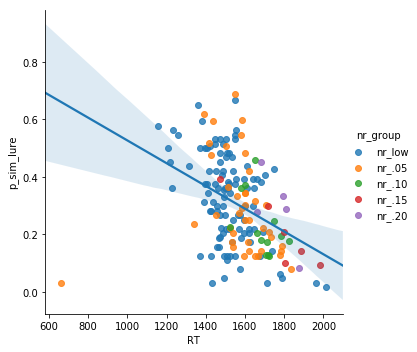

In [57]:
# plot median RT for correct lures versus the proportion correct on lure trials
g=sns.lmplot(x='RT', y='p_sim_lure', data=med_rt_cond_acc[(med_rt_cond_acc['Cond']=='Lure') & (med_rt_cond_acc['Acc']=='Correct')], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g=sns.regplot(x='RT', y='p_sim_lure', data= med_rt_cond_acc[(med_rt_cond_acc['Cond']=='Lure') & (med_rt_cond_acc['Acc']=='Correct')], scatter=False)

In [58]:
## find out who the outliers are 
print(med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['RT']< 800)])

      pidn  Cond     Resp  Trial  LBin     RT  num_targ_tr  num_foil_tr  \
5      449  Lure  No Resp   45.0   5.0    0.0         63.0         63.0   
16     456  Lure  No Resp   33.0   4.0    0.0         63.0         64.0   
49     470  Lure  No Resp   30.5   3.0    0.0         64.0         64.0   
59     472  Lure  No Resp  107.0   4.0    0.0         64.0         64.0   
69     474  Lure  No Resp  142.0   5.0    0.0         64.0         64.0   
80     475  Lure  No Resp   58.5   2.5    0.0         61.0         64.0   
92     476  Lure  No Resp  103.5   2.5    0.0         64.0         64.0   
112    478  Lure  No Resp   37.0   2.5    0.0         64.0         64.0   
122    479  Lure  No Resp   45.0   4.0    0.0         64.0         64.0   
133    481  Lure  No Resp   83.5   2.5    0.0         64.0         64.0   
142    482  Lure  No Resp    2.0   5.0    0.0         64.0         64.0   
164    489  Lure  No Resp   16.0   2.0    0.0         64.0         64.0   
195    507  Lure  No Resp

In [59]:
## print the trials for the outlier on correct trials
print(data_long[(data_long['pidn']==1185) & (data_long['Cond']=='Lure')])

       Trial   Img  Cond  LBin     Resp        Acc    RT  pidn
31682      3  171b  Lure     4  Similar    Correct   580  1185
31683      4  127b  Lure     1  Similar    Correct   747  1185
31687      8  144b  Lure     4      Old  Incorrect   879  1185
31688      9  002b  Lure     1      Old  Incorrect   900  1185
31692     13  146b  Lure     5  No Resp  Incorrect     0  1185
31693     14  028b  Lure     4      Old  Incorrect  1432  1185
31696     17  142b  Lure     2      Old  Incorrect  1538  1185
31697     18  166b  Lure     4      New  Incorrect  1619  1185
31699     20  063b  Lure     5      Old  Incorrect  1450  1185
31702     23  047b  Lure     1      Old  Incorrect  1068  1185
31703     24  094b  Lure     3      Old  Incorrect   986  1185
31705     26  184b  Lure     3      Old  Incorrect  1281  1185
31706     27  052b  Lure     1      Old  Incorrect   918  1185
31707     28  084b  Lure     5      Old  Incorrect  1452  1185
31710     31  162b  Lure     5      Old  Incorrect  124

In [60]:
## create a temporary data frame without the outlier
temp1= med_rt_cond_acc[med_rt_cond_acc['pidn'] !=1185]

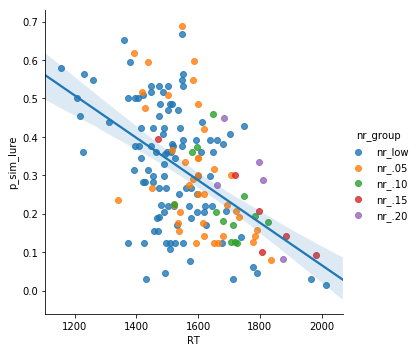

In [61]:
# plot median RT for correct lures versus the proportion correct on lure trials without outlier
g=sns.lmplot(x='RT', y='p_sim_lure', data=temp1[(temp1['Cond']=='Lure') & (temp1['Acc']=='Correct')], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g=sns.regplot(x='RT', y='p_sim_lure', data= temp1[(temp1['Cond']=='Lure') & (temp1['Acc']=='Correct')], scatter=False)

In [62]:
# calculate correlation value for correct lure RT versus proportion correct without outlier
pearsonr(x=temp1[(temp1['Cond']=='Lure') & (temp1['Acc']=='Correct')]['RT'], y = temp1[(temp1['Cond']=='Lure') & (temp1['Acc']=='Correct')]['p_sim_lure'])

(-0.5208101754157047, 3.9106291026179907e-13)

# Plotting Lure RT vs 
    #d' BPS
    #Percent Response Type
# by trial type

Text(0.5, 20.80000000000002, '"New" RT')

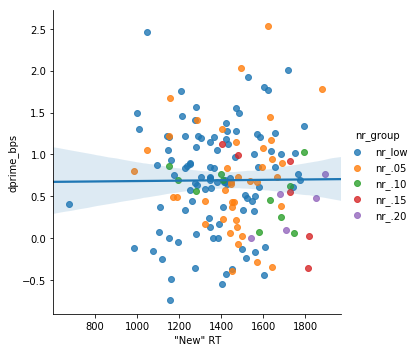

In [63]:
## plot Lure RT for "New" Responses vs d' BPS
# color code by NR group, but plot the regression line over all participants
g=sns.lmplot(x='RT', y='dprime_bps', data=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='New')], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='RT', y='dprime_bps', data=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='New')], scatter=False)
plt.xlabel('\"New\" RT')

In [64]:
# calculate correlation value for Lure RT for "New" Responses vs d' BPS
pearsonr(x=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='New')]['RT'], y= med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='New')]['dprime_bps'])

(0.008413423542540583, 0.9148507284481187)

Text(0.5, 20.80000000000002, '"Similar" RT')

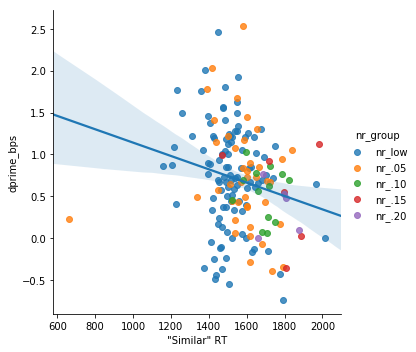

In [65]:
## plot Lure RT for "Similar" Responses vs d' BPS
# color code by NR group, but plot the regression line over all participants
g=sns.lmplot(x='RT', y='dprime_bps', data=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Similar')], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='RT', y='dprime_bps', data=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Similar')], scatter=False)
plt.xlabel('\"Similar\" RT')

In [66]:
# calculate correlation value for Lure RT for "Similar" Responses vs d' BPS
pearsonr(x=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Similar')]['RT'], y= med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Similar')]['dprime_bps'])

(-0.21475788506616958, 0.004918375493356417)

Text(0.5, 20.80000000000002, '"Old" RT')

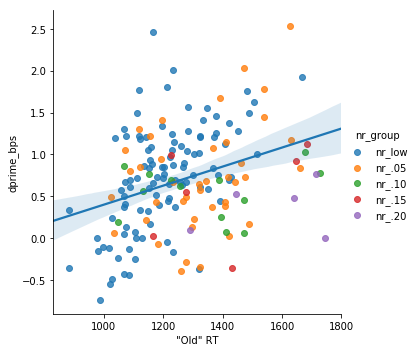

In [67]:
## plot Lure RT for "Old" Responses vs d' BPS
# color code by NR group, but plot the regression line over all participants
g=sns.lmplot(x='RT', y='dprime_bps', data=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Old')], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='RT', y='dprime_bps', data=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Old')], scatter=False)
plt.xlabel('\"Old\" RT')

In [68]:
# calculate correlation value for Lure RT for "Old" Responses vs d' BPS
pearsonr(x=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Old')]['RT'], y= med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Old')]['dprime_bps'])

(0.3361533695356747, 7.405636549536688e-06)

Text(0.5, 20.80000000000002, '"Old" RT')

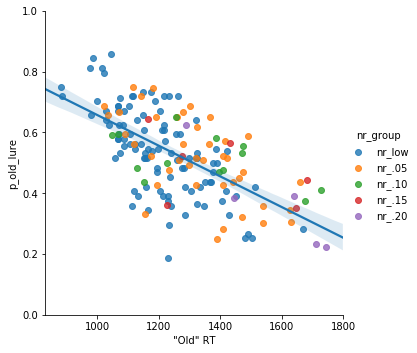

In [69]:
##plot RT on 'Old'|Lure Trials vs the propability of answering 'Old'|Lure
#color code by nr group, but plot the regression line over all points
g=sns.lmplot(x='RT', y='p_old_lure', data=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Old')], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='RT', y='p_old_lure', data=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Old')], scatter=False)
g.set(ylim=[0, 1])
plt.xlabel('\"Old\" RT')

In [70]:
##calculate correlation of RT on 'Old'|Lure Trials vs the propability of answering 'Old'|Lure
pearsonr(x=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Old')]['RT'], y=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Old')]['p_old_lure'])

(-0.6417769329183429, 4.101724147776938e-21)

Text(0.5, 20.80000000000002, '"Similar" RT')

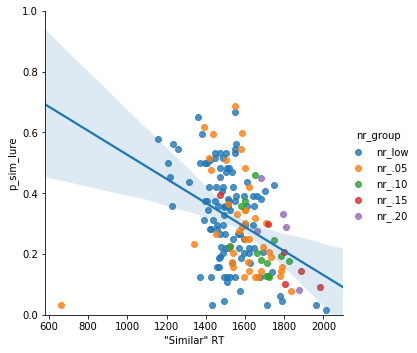

In [71]:
##plot RT on 'Sim'|Lure Trials vs the propability of answering 'Sim'|Lure
#color code by nr group, but plot the regression line over all points
g=sns.lmplot(x='RT', y='p_sim_lure', data=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Similar')], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='RT', y='p_sim_lure', data=med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['Resp']=='Similar')], scatter=False)
g.set(ylim=[0, 1])
plt.xlabel('\"Similar\" RT')

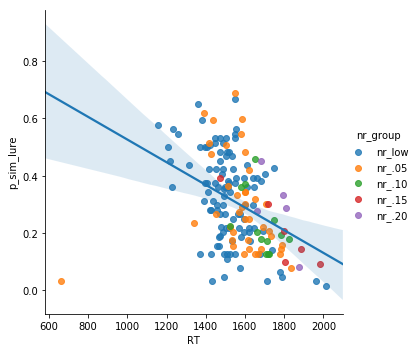

In [72]:
# plot median RT for correct lures versus the proportion correct on lure trials
g=sns.lmplot(x='RT', y='p_sim_lure', data=med_rt_cond_acc[(med_rt_cond_acc['Cond']=='Lure') & (med_rt_cond_acc['Acc']=='Correct')], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g=sns.regplot(x='RT', y='p_sim_lure', data= med_rt_cond_acc[(med_rt_cond_acc['Cond']=='Lure') & (med_rt_cond_acc['Acc']=='Correct')], scatter=False)

In [73]:
## find out who the outliers are 
print(med_rt_resp[(med_rt_resp['Cond']=='Lure') & (med_rt_resp['RT']< 800)])

      pidn  Cond     Resp  Trial  LBin     RT  num_targ_tr  num_foil_tr  \
5      449  Lure  No Resp   45.0   5.0    0.0         63.0         63.0   
16     456  Lure  No Resp   33.0   4.0    0.0         63.0         64.0   
49     470  Lure  No Resp   30.5   3.0    0.0         64.0         64.0   
59     472  Lure  No Resp  107.0   4.0    0.0         64.0         64.0   
69     474  Lure  No Resp  142.0   5.0    0.0         64.0         64.0   
80     475  Lure  No Resp   58.5   2.5    0.0         61.0         64.0   
92     476  Lure  No Resp  103.5   2.5    0.0         64.0         64.0   
112    478  Lure  No Resp   37.0   2.5    0.0         64.0         64.0   
122    479  Lure  No Resp   45.0   4.0    0.0         64.0         64.0   
133    481  Lure  No Resp   83.5   2.5    0.0         64.0         64.0   
142    482  Lure  No Resp    2.0   5.0    0.0         64.0         64.0   
164    489  Lure  No Resp   16.0   2.0    0.0         64.0         64.0   
195    507  Lure  No Resp

In [74]:
## print the trials for the outlier on correct trials
print(data_long[(data_long['pidn']==1185) & (data_long['Cond']=='Lure')])

       Trial   Img  Cond  LBin     Resp        Acc    RT  pidn
31682      3  171b  Lure     4  Similar    Correct   580  1185
31683      4  127b  Lure     1  Similar    Correct   747  1185
31687      8  144b  Lure     4      Old  Incorrect   879  1185
31688      9  002b  Lure     1      Old  Incorrect   900  1185
31692     13  146b  Lure     5  No Resp  Incorrect     0  1185
31693     14  028b  Lure     4      Old  Incorrect  1432  1185
31696     17  142b  Lure     2      Old  Incorrect  1538  1185
31697     18  166b  Lure     4      New  Incorrect  1619  1185
31699     20  063b  Lure     5      Old  Incorrect  1450  1185
31702     23  047b  Lure     1      Old  Incorrect  1068  1185
31703     24  094b  Lure     3      Old  Incorrect   986  1185
31705     26  184b  Lure     3      Old  Incorrect  1281  1185
31706     27  052b  Lure     1      Old  Incorrect   918  1185
31707     28  084b  Lure     5      Old  Incorrect  1452  1185
31710     31  162b  Lure     5      Old  Incorrect  124

In [75]:
## create a temporary data frame without the outlier
temp1= med_rt_cond_acc[med_rt_cond_acc['pidn'] !=1185]

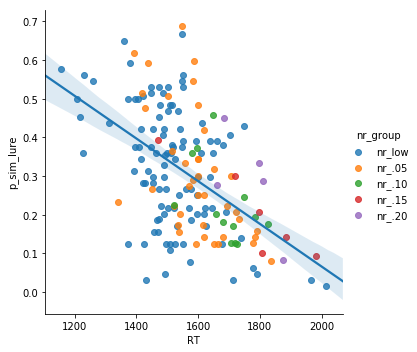

In [76]:
# plot median RT for correct lures versus the proportion correct on lure trials without outlier
g=sns.lmplot(x='RT', y='p_sim_lure', data=temp1[(temp1['Cond']=='Lure') & (temp1['Acc']=='Correct')], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g=sns.regplot(x='RT', y='p_sim_lure', data= temp1[(temp1['Cond']=='Lure') & (temp1['Acc']=='Correct')], scatter=False)

In [77]:
# calculate correlation value for correct lure RT versus proportion correct without outlier
pearsonr(x=temp1[(temp1['Cond']=='Lure') & (temp1['Acc']=='Correct')]['RT'], y = temp1[(temp1['Cond']=='Lure') & (temp1['Acc']=='Correct')]['p_sim_lure'])

(-0.5208101754157047, 3.9106291026179907e-13)

In [78]:
## print outlier data
print(med_rt_resp[(med_rt_resp['RT']<800) & (med_rt_resp['Cond'] =='Lure')])

      pidn  Cond     Resp  Trial  LBin     RT  num_targ_tr  num_foil_tr  \
5      449  Lure  No Resp   45.0   5.0    0.0         63.0         63.0   
16     456  Lure  No Resp   33.0   4.0    0.0         63.0         64.0   
49     470  Lure  No Resp   30.5   3.0    0.0         64.0         64.0   
59     472  Lure  No Resp  107.0   4.0    0.0         64.0         64.0   
69     474  Lure  No Resp  142.0   5.0    0.0         64.0         64.0   
80     475  Lure  No Resp   58.5   2.5    0.0         61.0         64.0   
92     476  Lure  No Resp  103.5   2.5    0.0         64.0         64.0   
112    478  Lure  No Resp   37.0   2.5    0.0         64.0         64.0   
122    479  Lure  No Resp   45.0   4.0    0.0         64.0         64.0   
133    481  Lure  No Resp   83.5   2.5    0.0         64.0         64.0   
142    482  Lure  No Resp    2.0   5.0    0.0         64.0         64.0   
164    489  Lure  No Resp   16.0   2.0    0.0         64.0         64.0   
195    507  Lure  No Resp

Text(0.5, 20.80000000000002, '"New" RT')

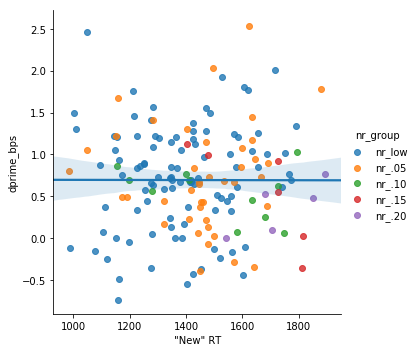

In [79]:
## plot the data for d' bps versus rt for New|Targ trials without outlier
temp3= med_rt_resp[med_rt_resp['pidn'] !=532]

sns.lmplot(x='RT', y='dprime_bps', data=temp3[(temp3['Cond']=='Lure') & (temp3['Resp']=='New')], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='RT', y='dprime_bps', data=temp3[(temp3['Cond']=='Lure') & (temp3['Resp']=='New')], scatter=False)
plt.xlabel('\"New\" RT')

In [80]:
## calcilate correlation of RT on 'New'|Lure Trials vs the propability of answering 'New'|Lure
pearsonr(x=temp3[(temp3['Cond']=='Lure') & (temp3['Resp']=='New')]['RT'], y=temp3[(temp3['Cond']=='Lure') & (temp3['Resp']=='New')]['p_sim_lure'])

(0.08091139830339918, 0.30454189793522624)

# Start Demographics Correlations

[(0, 1)]

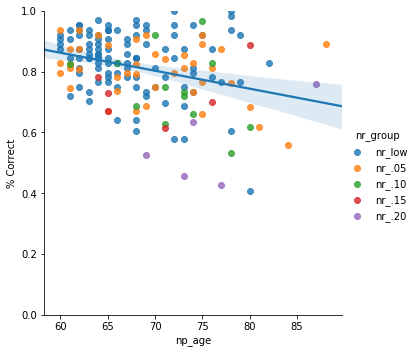

In [81]:
# plot age versus percent correct on target trials 
g=sns.lmplot(x='np_age', y='p_old_targ', data=med_rt_cond[med_rt_cond['Cond']=='Target'], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='np_age', y='p_old_targ', data=med_rt_cond[med_rt_cond['Cond']=='Target'], scatter=False)
plt.ylabel('% Correct')
g.set(ylim=[0,1])

In [82]:
#calculate correlation value for age versus proportion correct on target trials
pearsonr(x=med_rt_cond[med_rt_cond['Cond']=='Target']['np_age'], y = med_rt_cond[med_rt_cond['Cond']=='Target']['p_old_targ'])

(-0.3120843854405929, 3.427665233266148e-05)

[(0, 1)]

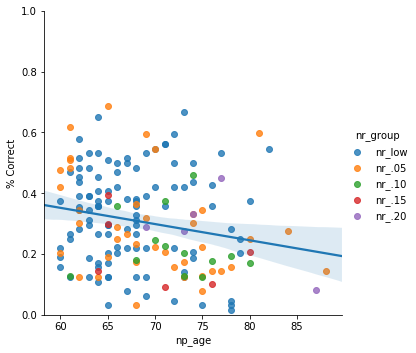

In [83]:
#plot age versus proportion correct on lure trials 
g=sns.lmplot(x='np_age', y='p_sim_lure', data=med_rt_cond[med_rt_cond['Cond']=='Lure'], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='np_age', y='p_sim_lure', data=med_rt_cond[med_rt_cond['Cond']=='Lure'], scatter=False)
plt.ylabel('% Correct')
g.set(ylim=[0,1])

In [84]:
#calculate correlation for age versus percent correct on lure trials 
pearsonr(x=med_rt_cond[med_rt_cond['Cond']=='Lure']['np_age'], y = med_rt_cond[med_rt_cond['Cond']=='Lure']['p_sim_lure'])

(-0.20686578795147142, 0.006796767532168456)

[(0, 1)]

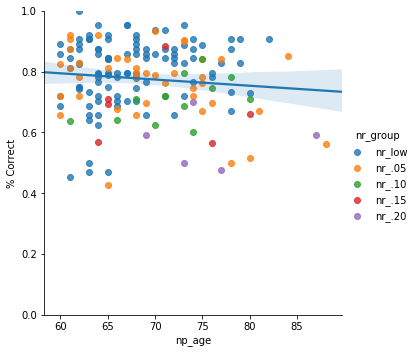

In [85]:
#plot age versus percent correct on foil trials 
g=sns.lmplot(x='np_age', y='p_new_foil', data=med_rt_cond[med_rt_cond['Cond']=='Foil'], hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='np_age', y='p_new_foil', data=med_rt_cond[med_rt_cond['Cond']=='Foil'], scatter=False)
plt.ylabel('% Correct')
g.set(ylim=[0,1])

In [86]:
# calculate correlation value for age versus percent correct on foil trials
pearsonr(x=med_rt_cond[med_rt_cond['Cond']=='Foil']['np_age'], y=med_rt_cond[med_rt_cond['Cond']=='Foil']['p_new_foil'])

(-0.1062713932552166, 0.167803625101766)

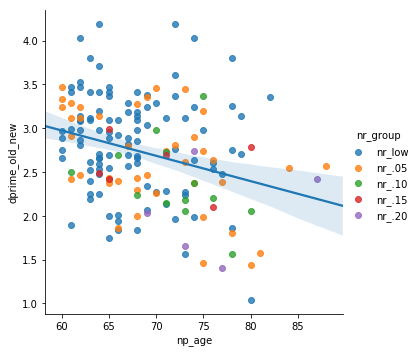

In [87]:
#plot age versus old/new d'
g=sns.lmplot(x='np_age', y='dprime_old_new', data=med_rt_all, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='np_age', y='dprime_old_new', data=med_rt_all, scatter=False)

In [88]:
pearsonr(x=med_rt_all['np_age'], y=med_rt_all['dprime_old_new'])

(-0.30053835941385626, 6.831326738578003e-05)

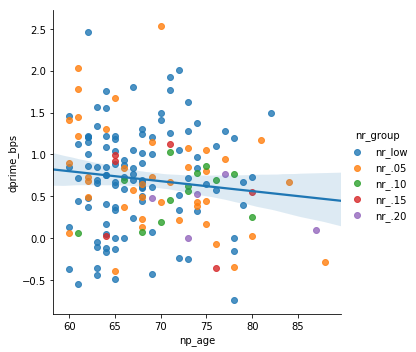

In [89]:
#plot age versus dprime bps
g=sns.lmplot(x='np_age', y='dprime_bps', data=med_rt_all, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='np_age', y='dprime_bps', data=med_rt_all, scatter=False)

In [90]:
#calculate correlation value for age versus d' bps
pearsonr(x=med_rt_all['np_age'], y=med_rt_all['dprime_bps'])

(-0.12002520677712776, 0.11898865524486976)

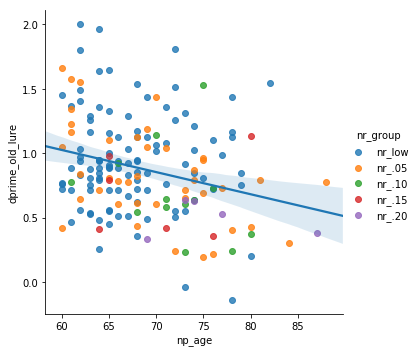

In [91]:
#plot age versus d' old/lure
g=sns.lmplot(x='np_age', y='dprime_old_lure', data=med_rt_all, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='np_age', y='dprime_old_lure', data=med_rt_all, scatter=False)

In [92]:
#calculate correlation value for age versus d' old/similar
pearsonr(x=med_rt_all['np_age'], y=med_rt_all['dprime_old_lure'])

(-0.26985021199872683, 0.0003726832042731065)

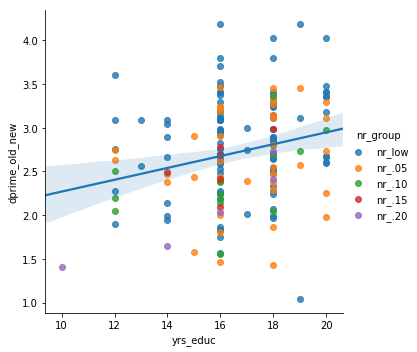

In [93]:
#plot education versus d' o/n
g=sns.lmplot(x='yrs_educ', y='dprime_old_new', data=med_rt_all, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='yrs_educ', y='dprime_old_new', data=med_rt_all, scatter=False)

In [94]:
#calculate correlation of education versus d' o/n
pearsonr(x=med_rt_all['yrs_educ'], y=med_rt_all['dprime_old_new'])

(0.23932341589684078, 0.0016712365936158201)

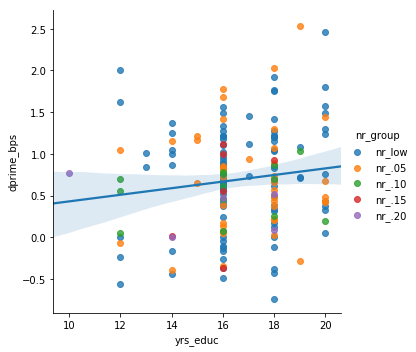

In [95]:
#plot years education versus d' bps
g=sns.lmplot(x='yrs_educ', y='dprime_bps', data=med_rt_all, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='yrs_educ', y='dprime_bps', data=med_rt_all, scatter=False)

In [96]:
#calculate correlation of education versus d' bps
pearsonr(x=med_rt_all['yrs_educ'], y=med_rt_all['dprime_bps'])

(0.13545050223913982, 0.07821231404974202)

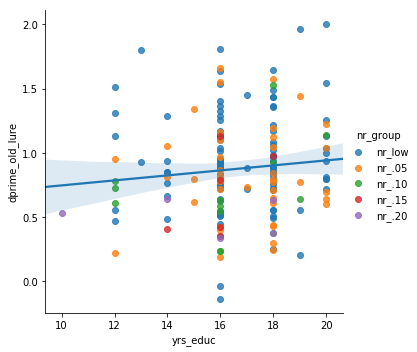

In [97]:
#plot education verus d' o/s
g=sns.lmplot(x='yrs_educ', y='dprime_old_lure', data=med_rt_all, hue='nr_group', hue_order=['nr_low', 'nr_.05', 'nr_.10', 'nr_.15', 'nr_.20'], fit_reg=False)
g= sns.regplot(x='yrs_educ', y='dprime_old_lure', data=med_rt_all, scatter=False)

In [98]:
#calculate correlation value for education versus d' o/s
pearsonr(x=med_rt_all['yrs_educ'], y=med_rt_all['dprime_old_lure'])

(0.10369655082661558, 0.1784015157687915)

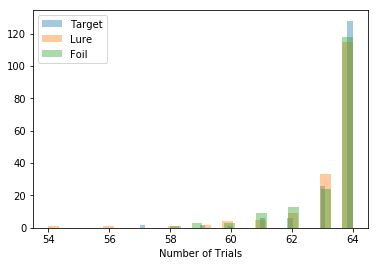

In [99]:
#plot the number of trials for each condition participants have
g= sns.distplot(all_data['num_targ_tr'], kde=False)
g=sns.distplot(all_data['num_lure_tr'], kde=False)
g=sns.distplot(all_data['num_foil_tr'], kde=False)
plt.xlabel('Number of Trials')
plt.legend(['Target', 'Lure', 'Foil'])

[(35, 65)]

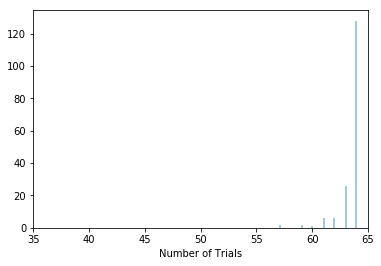

In [100]:
#plot the number of target trials each participant has
g= sns.distplot(all_data['num_targ_tr'], kde=False)
plt.xlabel('Number of Trials')
g.set(xlim=[35, 65])

[(35, 65)]

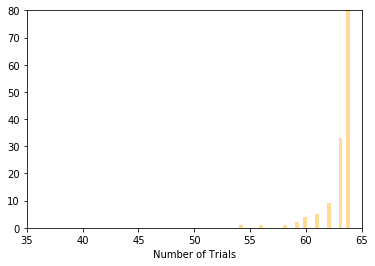

In [101]:
#plot the number of lure trials each participant has
g=sns.distplot(all_data['num_lure_tr'], kde=False, color='orange')
plt.xlabel('Number of Trials')
g.set(ylim=[0, 80])
g.set(xlim=[35, 65])

In [102]:
#print data for the "outlier" (in quotes because it might not be statistically significant)
print(am_data[am_data['pidn']==809])

     pidn   assoc_d  old_new_d  num_targ_tr  num_foil_tr  num_lure_tr  num_nr  \
63  809.0  0.731903   1.591801         57.0         61.0         54.0    35.0   

    num_nr_t  num_nr_l  num_nr_f    ...      lm2  lmpr  mmse_norm  \
63      11.0      17.0       7.0    ...     26.0  93.0  -0.028863   

    hvltr4_norm  bvmtr4_norm  lm2_norm  immediate_recall_comp  \
63    -0.076983    -0.455443 -0.679479              -0.598741   

    delayed_recall_comp  recognition_comp  nr_group  
63            -0.403968          0.307584    nr_.15  

[1 rows x 55 columns]


[(35, 65)]

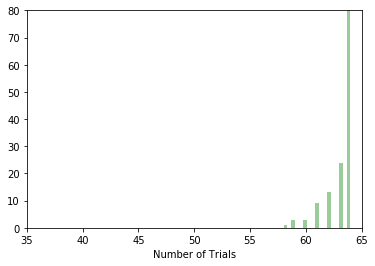

In [103]:
#plot the number of foil trials that each participant has
g=sns.distplot(all_data['num_foil_tr'], kde=False, color='green')
plt.xlabel('Number of Trials')
g.set(ylim=[0, 80])
g.set(xlim=[35, 65])

In [104]:
## create a data frame with a summary of lure trials 
row=0 
resp_sum_data=pd.DataFrame()

for pidn in pd.unique(data_long['pidn']):
    resp_sum_data.loc[row, 'pidn'] = pidn
    resp_sum_data.loc[row, 'num_sim'] = len(data_long[(data_long['pidn']==pidn) & (data_long['Resp']=='Similar')])
    resp_sum_data.loc[row, 'num_trials'] = len(data_long[data_long['pidn']==pidn])
    resp_sum_data.loc[row, 'prop_sim'] = resp_sum_data.loc[row, 'num_sim']/resp_sum_data.loc[row, 'num_trials']
    row+=1
    
print(resp_sum_data)

       pidn  num_sim  num_trials  prop_sim
0     449.0     13.0       189.0  0.068783
1     456.0     24.0       190.0  0.126316
2     457.0     24.0       192.0  0.125000
3     468.0      6.0       191.0  0.031414
4     470.0      2.0       192.0  0.010417
5     472.0     46.0       191.0  0.240838
6     474.0      8.0       192.0  0.041667
7     475.0     29.0       187.0  0.155080
8     476.0     16.0       192.0  0.083333
9     477.0     36.0       192.0  0.187500
10    478.0     39.0       192.0  0.203125
11    479.0     60.0       192.0  0.312500
12    481.0     50.0       191.0  0.261780
13    482.0      5.0       192.0  0.026042
14    488.0     37.0       192.0  0.192708
15    489.0     61.0       191.0  0.319372
16    500.0     22.0       192.0  0.114583
17    504.0     30.0       192.0  0.156250
18    507.0     54.0       192.0  0.281250
19    508.0     31.0       192.0  0.161458
20    530.0     67.0       189.0  0.354497
21    532.0     43.0       192.0  0.223958
22    534.0

In [105]:
#print the data for anyone who responds to lures correctly less than 5% of the time
print(resp_sum_data[resp_sum_data['prop_sim']<.05])

       pidn  num_sim  num_trials  prop_sim
3     468.0      6.0       191.0  0.031414
4     470.0      2.0       192.0  0.010417
6     474.0      8.0       192.0  0.041667
13    482.0      5.0       192.0  0.026042
49    674.0      8.0       192.0  0.041667
79    793.0      8.0       192.0  0.041667
88    828.0      9.0       190.0  0.047368
106   899.0      5.0       190.0  0.026316
139  1030.0      8.0       192.0  0.041667
140  1031.0      2.0       191.0  0.010471
162  1184.0      9.0       189.0  0.047619
163  1185.0      3.0       191.0  0.015707


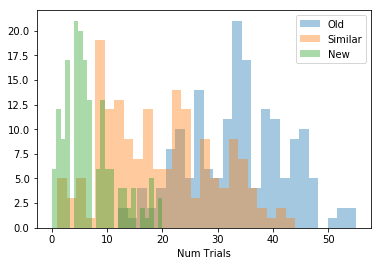

In [106]:
#plot the number of times a person responds each response to lure trials  
sns.distplot(all_data['n_old_lure'], kde=0, bins=25)
sns.distplot(all_data['n_sim_lure'], kde=0, bins=25)
sns.distplot(all_data['n_new_lure'], kde=0, bins=25)
plt.xlabel('Num Trials')
plt.legend(['Old', 'Similar', 'New'])

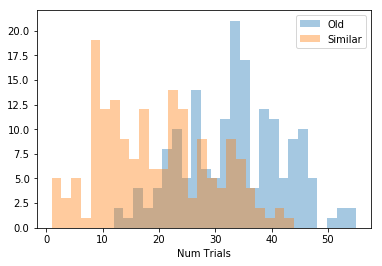

In [107]:
#plot the graph above without new trials in order to see easier
sns.distplot(all_data['n_old_lure'], kde=0, bins=25)
sns.distplot(all_data['n_sim_lure'], kde=0, bins=25)
plt.xlabel('Num Trials')
plt.legend(['Old', 'Similar'])

In [108]:
#create csv with data
all_data.to_csv('/Users/madisonhunt/Desktop/mst_data_with_nr.csv')

In [109]:
data_long.to_csv('/Users/madisonhunt/Desktop/data_long_with_nr.csv')